In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
adata = sc.read_h5ad('data/COVID19_RNA_HeathLab_20K.h5ad')

In [4]:
adata.var

,highly_variable,means,dispersions,dispersions_norm,mean,std
A2M-AS1,True,1.690908,6.668022,0.354610,0.053017,0.565018
A2ML1,True,0.008557,7.008286,1.828369,0.000103,0.024462
A3GALT2,True,0.013208,6.636930,0.806058,0.000145,0.030034
ABALON,True,0.331703,6.482601,0.381202,0.005469,0.179730
ABCA1,True,3.563781,6.913508,1.176540,0.364771,1.454412
...,...,...,...,...,...,...
ZNF709,True,0.090734,6.690875,0.954565,0.001190,0.084508
ZNF732,True,0.007282,6.617630,0.752925,0.000095,0.023684
ZNRF3-AS1,True,0.013796,7.002162,1.811511,0.000133,0.028810
ZRANB2-AS1,True,0.035509,6.589002,0.674117,0.000509,0.054661


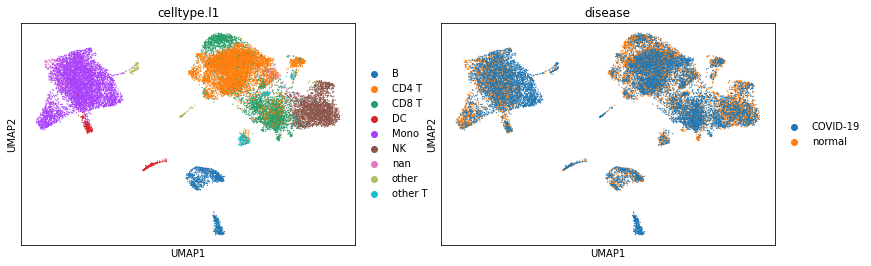

In [5]:
sc.pl.umap(adata, color=['celltype.l1', 'disease'])

In [6]:
 
import collections
elements_count = collections.Counter(np.sort( adata.obs['celltype.l1']))
# printing the element and the frequency
for key, value in elements_count.items():
   print(f"{key}: {value}")

B: 954
CD4 T: 6865
CD8 T: 3035
DC: 348
Mono: 5296
NK: 2436
nan: 524
other: 156
other T: 386


In [7]:
elements_count = collections.Counter(np.sort( adata.obs['celltype.l1']))
# printing the element and the frequency
for key, value in elements_count.items():
   print(f"{key}: {value}")

B: 954
CD4 T: 6865
CD8 T: 3035
DC: 348
Mono: 5296
NK: 2436
nan: 524
other: 156
other T: 386


In [8]:
  
from collections import defaultdict 
# converts from adjacency matrix to adjacency list 
def convert(a): 
    adjList = defaultdict(list) 
    adjList_value = defaultdict(list) 
    for i in range(len(a)): 
        for j in range(len(a[i])): 
                       if a[i][j] != 0: 
                           adjList[i].append(j)
                           adjList_value[i].append( a[i][j])
    return adjList, adjList_value 
  
 
edgeList, edgeList_value = convert(adata.obsp['connectivities'].toarray()) 


In [9]:
node_1 =[]
node_2 =[]
node_3 = []
for i in range(len(edgeList)):
    node_1.extend([i] * len(edgeList[i]))
    node_2.extend(edgeList[i])
    node_3.extend(edgeList_value[i])

 

In [10]:
adata.obs['disease_num'] = adata.obs['disease']
adata.obs['disease_num'] = adata.obs['disease_num'].replace(['normal'],'0')

adata.obs['disease_num'] = adata.obs['disease_num'].replace(['COVID-19'],'1')

elements_count = collections.Counter(np.sort( adata.obs['disease_num']))
# printing the element and the frequency
for key, value in elements_count.items():
   print(f"{key}: {value}")

0: 10000
1: 10000


In [11]:

import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F

Using backend: pytorch


Construct DGL object
--------------------------------------------


In [12]:


# Create a DGL graph from a pair of numpy arrays
g = dgl.graph((node_1, node_2))

 
edge_weight = torch.tensor(np.array(node_3))
# Similarly, use `g.edata` for getting/setting edge features.
g.edata['weight'] = edge_weight
print(g)
g.ndata['feat'] =   torch.tensor( adata.X)
g.ndata['label'] =   torch.tensor(adata.obs['disease_num'].astype('int64'))

Graph(num_nodes=20000, num_edges=626180,
      ndata_schemes={}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float32)})


In [13]:
g.ndata['train_mask'] =   torch.tensor([True]*len(g.ndata['label']))
g.ndata['val_mask'] = torch.tensor([False]*len(g.ndata['label']))
g.ndata['test_mask'] = torch.tensor([False]*len(g.ndata['label']))

In [14]:
from random import sample

test_index = sample(range(len(g.ndata['label'])), k = 2000)
val_index = sample(set([*range(len(g.ndata['label'])) ]) - set(test_index), k = 1000)



In [15]:
g.ndata['val_mask'][val_index] = True
g.ndata['test_mask'][test_index] = True
g.ndata['train_mask'][val_index] = False
g.ndata['train_mask'][test_index] = False


In [16]:
np.unique(g.ndata['label'])

array([0, 1], dtype=int64)

Defining a Graph Convolutional Network (GCN)
--------------------------------------------




In [17]:
from dgl.nn import GraphConv

class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)
    
    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h
    


Training the GCN
----------------

Training this GCN is similar to training other PyTorch neural networks.




In [18]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    all_logits = []
    
    for e in range(100):
        # Forward
      
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)
        #pdb.set_trace()
        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        all_logits.append(logits.detach())
        if e % 5 == 0:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
    return(all_logits)


In [19]:
model = GCN(g.ndata['feat'].shape[1], 50, len(np.unique(g.ndata['label'])))
all_logits = train(g, model)

In epoch 0, loss: 0.732, val acc: 0.467 (best 0.467), test acc: 0.495 (best 0.495)
In epoch 5, loss: 0.687, val acc: 0.564 (best 0.608), test acc: 0.588 (best 0.555)
In epoch 10, loss: 0.635, val acc: 0.625 (best 0.625), test acc: 0.633 (best 0.633)
In epoch 15, loss: 0.610, val acc: 0.673 (best 0.673), test acc: 0.668 (best 0.668)
In epoch 20, loss: 0.584, val acc: 0.697 (best 0.697), test acc: 0.685 (best 0.685)
In epoch 25, loss: 0.560, val acc: 0.713 (best 0.713), test acc: 0.706 (best 0.706)
In epoch 30, loss: 0.538, val acc: 0.714 (best 0.730), test acc: 0.721 (best 0.710)
In epoch 35, loss: 0.518, val acc: 0.736 (best 0.740), test acc: 0.715 (best 0.715)
In epoch 40, loss: 0.506, val acc: 0.745 (best 0.745), test acc: 0.717 (best 0.717)
In epoch 45, loss: 0.494, val acc: 0.763 (best 0.763), test acc: 0.734 (best 0.734)
In epoch 50, loss: 0.484, val acc: 0.773 (best 0.773), test acc: 0.740 (best 0.740)
In epoch 55, loss: 0.479, val acc: 0.773 (best 0.773), test acc: 0.747 (best 0

In [20]:
model

GCN(
  (conv1): GraphConv(in=5000, out=50, normalization=both, activation=None)
  (conv2): GraphConv(in=50, out=2, normalization=both, activation=None)
)

In [21]:

features = g.ndata['feat']
labels = g.ndata['label']
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']

logits = model(g, features)
pred = logits.argmax(1)
train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

In [22]:
print(test_acc)


tensor(0.7655)


In [23]:
celltype_set = np.unique(adata.obs['celltype.l1'] )
for i in celltype_set:
    if i != 'nan':
        celltype_index =   torch.tensor([False]*len(labels))
        celltype_index[np.where(adata.obs['celltype.l1'] == i)] = True
        celltype_test = test_mask * celltype_index
        test_acc_celltype = (pred[celltype_test] == labels[celltype_test]).float().mean()
        print(i,'acc {:.3f}'.format(test_acc_celltype))

B acc 0.760
CD4 T acc 0.723
CD8 T acc 0.739
DC acc 0.711
Mono acc 0.816
NK acc 0.786
other acc 0.706
other T acc 0.848


In [24]:
celltype_set = np.unique(adata.obs['celltype.l2'] )
for i in celltype_set:
    if i != 'nan':
        celltype_index =   torch.tensor([False]*len(labels))
        celltype_index[np.where(adata.obs['celltype.l2'] == i)] = True
        celltype_test = test_mask * celltype_index
        test_acc_celltype = (pred[celltype_test] == labels[celltype_test]).float().mean()
        print(i,'acc {:.3f}'.format(test_acc_celltype))

ASDC acc nan
B intermediate acc 0.955
B memory acc 0.700
B naive acc 0.692
CD14 Mono acc 0.824
CD16 Mono acc 0.769
CD4 CTL acc 0.839
CD4 Naive acc 0.749
CD4 Proliferating acc 0.667
CD4 TCM acc 0.687
CD4 TEM acc 0.740
CD8 Naive acc 0.720
CD8 Proliferating acc 1.000
CD8 TCM acc 0.500
CD8 TEM acc 0.764
Doublet acc nan
Eryth acc 0.000
HSPC acc 0.600
ILC acc 1.000
MAIT acc 0.800
NK acc 0.796
NK Proliferating acc 1.000
NK_CD56bright acc 0.500
Plasmablast acc 1.000
Platelet acc 0.778
Treg acc 0.650
cDC1 acc nan
cDC2 acc 0.750
dnT acc 1.000
gdT acc 0.867
pDC acc 0.667


In [25]:
emb = model.conv1(g,   g.ndata['feat']).detach().numpy() 

In [26]:
adata.obsm['X_gnn'] = emb
sc.pp.neighbors(adata , use_rep = 'X_gnn', n_pcs = 50)
sc.tl.umap(adata )

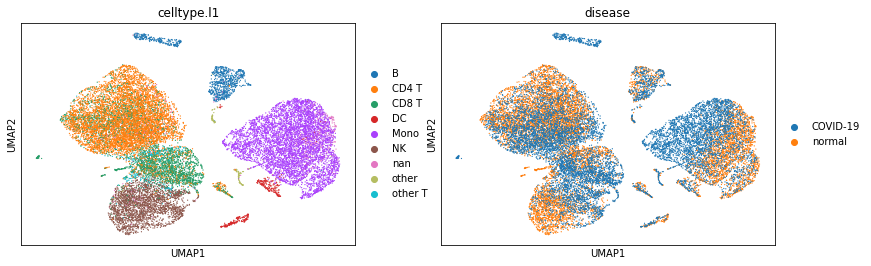

In [27]:
sc.pl.umap(adata, color=['celltype.l1', 'disease'])